In [1]:
import re
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import pearsonr
from datetime import datetime
import seaborn as sns
import sys
sys.path.append('../')
from helpers import *
from analysis_helper import *

data_path = './../../../data'

In [2]:
rb_dir = os.path.join(data_path, 'RateBeer')
exp_categories = get_exp_categories(data_path) + ['expertness_score']
rev_with_scores_rb = pd.read_pickle(os.path.join(rb_dir, 'rev_w_scores.pkl'))
rev_with_scores_rb['date'] = pd.to_datetime(rev_with_scores_rb['date'])
beers_rb = pd.read_csv(os.path.join(rb_dir, 'beers.csv'))
users = pd.read_csv(os.path.join(rb_dir, 'users_RB_clean.csv'))

In [3]:
rev_with_scores_rb.columns

Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv',
       'date', 'user_name', 'user_id', 'appearance_rt', 'aroma', 'palate',
       'taste', 'overall', 'rating', 'review', 'lang_tag', 'stems', 'flavor',
       'mouthfeel', 'brewing', 'technical', 'appearance', 'off_flavors',
       'expertness_score'],
      dtype='object')

In [4]:

scores_for_beer = get_scores_for_beers(rev_with_scores_rb, exp_categories)


In [5]:
mean_scores_beer = get_mean_scores_beer(rev_with_scores_rb, exp_categories)
complete_beer = pd.merge(beers_rb, mean_scores_beer, on='beer_id')

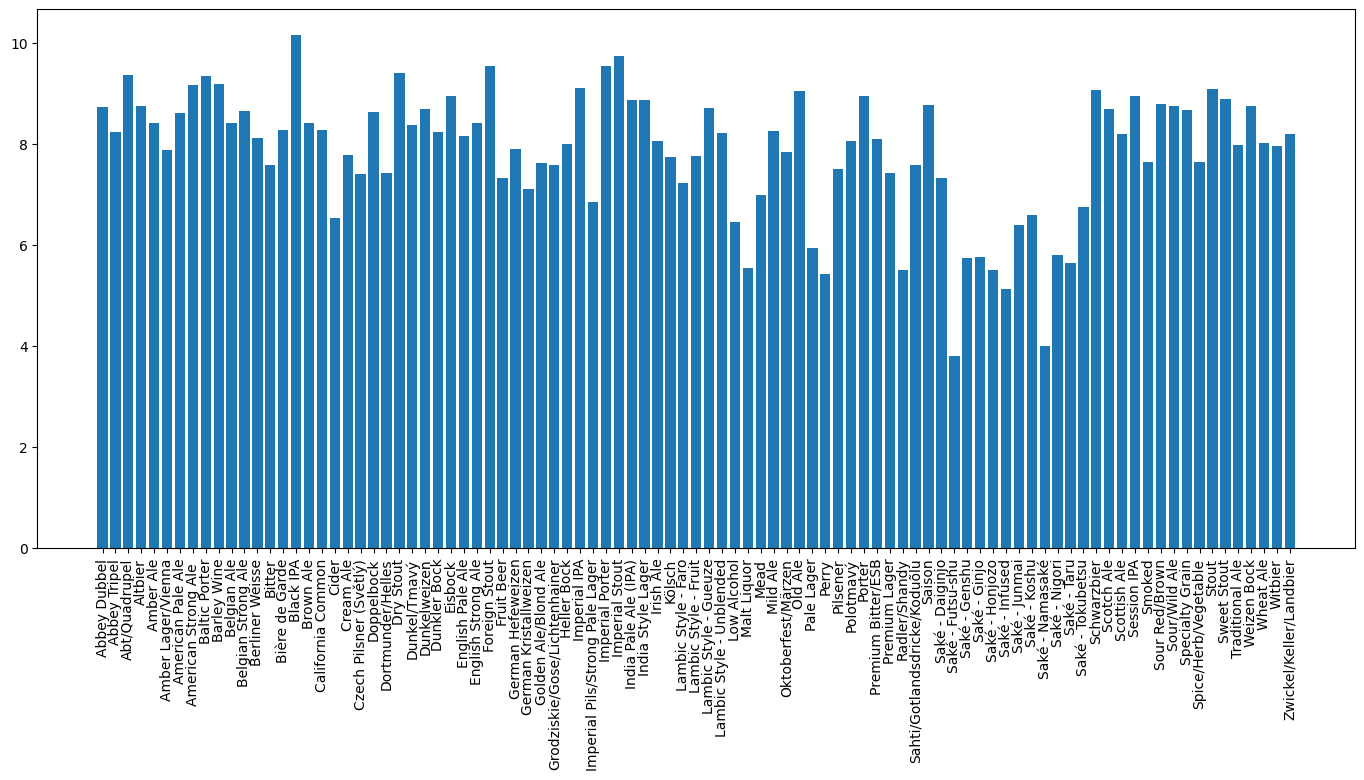

In [6]:
beer_gr = get_beer_gr(complete_beer, exp_categories)
fig  = plt.figure(figsize=(17,7))
plt.bar(beer_gr.index, beer_gr['expertness_score'])

plt.xticks(rotation=90)
plt.show()

In [7]:
mean_scores_beer['review_count'].corr(mean_scores_beer['expertness_score'])

-0.012904772003676825

<Axes: >

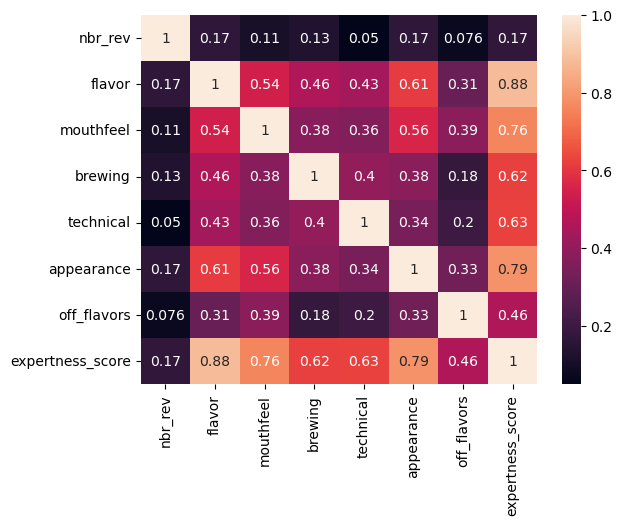

In [8]:
user_rb = get_users_stats(rev_with_scores_rb, exp_categories)
sns.heatmap(user_rb.corr(), annot=True)

<Axes: >

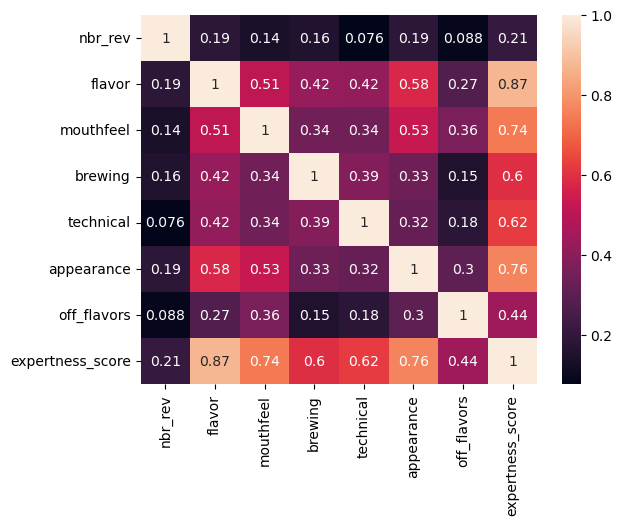

In [9]:
sns.heatmap(user_rb[user_rb['nbr_rev']<200].corr(), annot=True)

In [10]:
pearsonr(user_rb['expertness_score'], user_rb['nbr_rev'])

PearsonRResult(statistic=0.17429500141685259, pvalue=0.0)

In [11]:
# Normalizes review dates to the first review date for each user, setting their first review as day zero.
rev_zero_date= joined_date_zero(rev_with_scores_rb)
# Standardize the reviews score through the mean and the std of the scores for that particular beer 
rev_std = standardize(rev_zero_date, scores_for_beer.reset_index(), exp_categories)

result = rev_std.groupby('user_id').apply(corr_and_count, include_groups=False)

result = result.dropna()
result

/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_metric/../analysis_helper.py:93: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])
/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_metric/../analysis_helper.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_metric/../analysis_helper.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_metric/../analysis_helper.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value 

,correlation,p_value,total_count
user_id,,,
2,-0.103040,0.481099,49.0
3,-0.089488,0.191172,215.0
7,-0.134009,0.409714,40.0
10,-0.935139,0.019635,5.0
20,-0.490857,0.003727,33.0
...,...,...,...
487194,0.000000,1.000000,2.0
487447,1.000000,1.000000,2.0
487725,0.000000,1.000000,2.0


In [12]:
result[(result['total_count'] > 20) & (result['total_count'] < 500)]['correlation'].mean()

0.021783977395587725

In [13]:
result['correlation'].mean()

0.01615312669111892

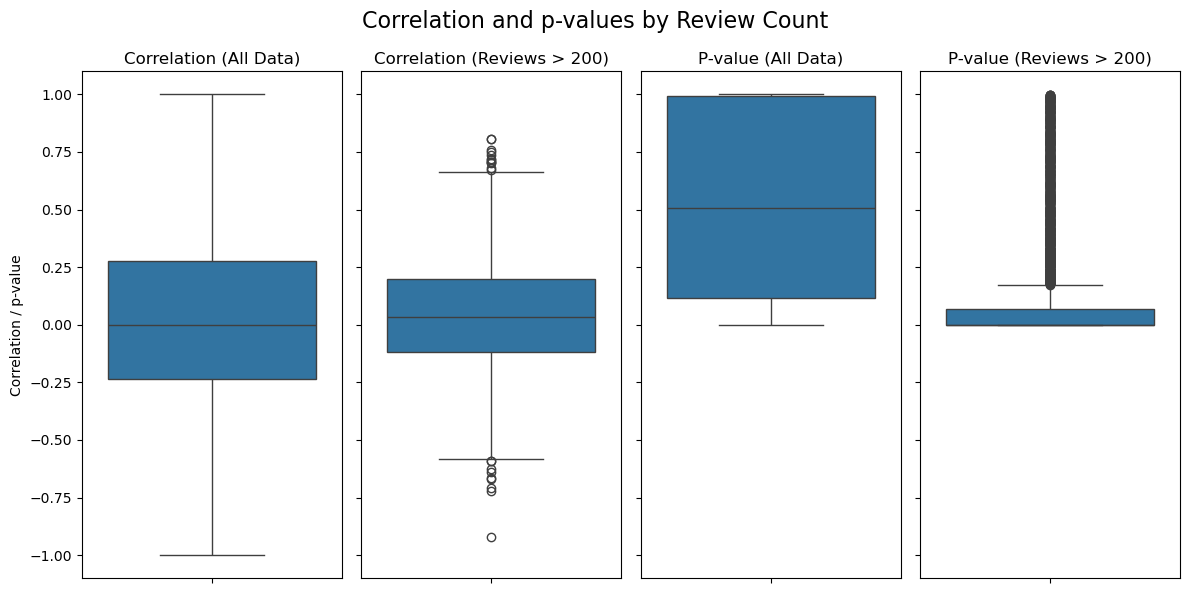

In [14]:
plot_corr_and_pvalue(result)

In [15]:
len(users[users['nbr_ratings']>200])

4425

In [16]:
def review_of_experts(df, users, nbr_rev=100):
    x = df.merge(users[['user_id','nbr_ratings']], on='user_id')
    return x[x['nbr_ratings']>nbr_rev]

In [17]:
rev_of_exp = review_of_experts(rev_with_scores_rb, users, nbr_rev=200)
rev_of_exp = first_reviews(rev_of_exp, max=100)
rev_exp_zero_date= joined_date_zero(rev_of_exp)

rev_exp_std = standardize(rev_exp_zero_date, scores_for_beer.reset_index(), exp_categories)
result = rev_exp_std.groupby('user_id').apply(corr_and_count, include_groups=False)

/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_metric/../analysis_helper.py:93: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])
/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_metric/../analysis_helper.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_metric/../analysis_helper.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_metric/../analysis_helper.py:138: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value 

In [18]:
result = result.dropna()

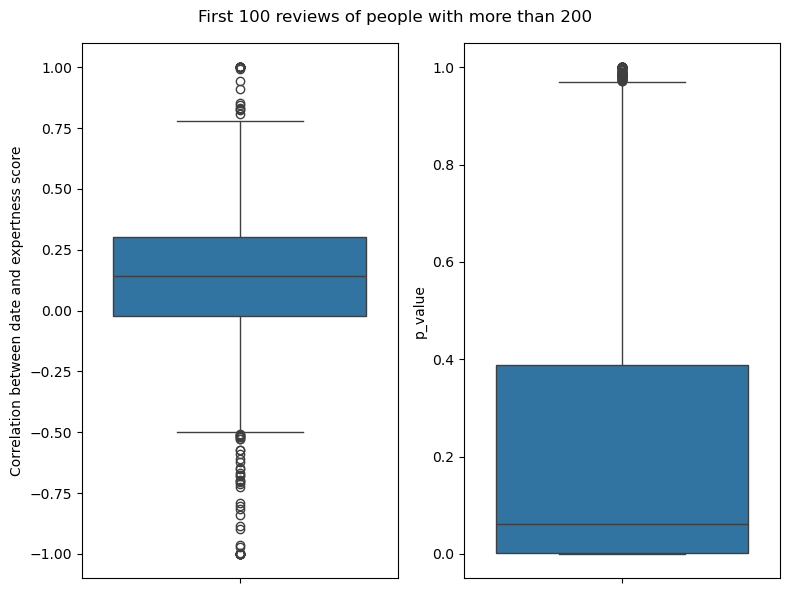

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6)) 

fig.suptitle('First 100 reviews of people with more than 200')

sns.boxplot(y=result['correlation'], ax=axes[0])

axes[0].set_ylabel("Correlation between date and expertness score")

sns.boxplot(y=result['p_value'], ax=axes[1])
axes[1].set_ylabel("p_value")

plt.tight_layout()  
plt.show()


In [20]:
result['correlation'].mean()

0.13570343575865135

In [21]:
rev_of_exp = review_of_experts(rev_with_scores_rb, users, nbr_rev=200)
rev_of_exp = first_reviews(rev_of_exp, max=5)

/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_metric/../analysis_helper.py:93: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])


Text(0.5, 1.0, 'Mean of the score (standardized) of the first 5 reviews of people with more than 200')

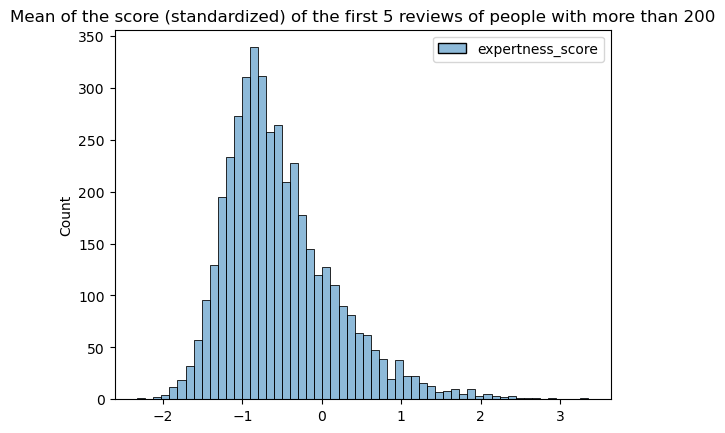

In [22]:
rev_exp_std = standardize(rev_of_exp, scores_for_beer.reset_index(), exp_categories)
rev_exp_std_grouped = rev_exp_std.groupby('user_id')[['expertness_score']].agg('mean')
sns.histplot(rev_exp_std_grouped)
plt.title('Mean of the score (standardized) of the first 5 reviews of people with more than 200')

In [23]:
no_already_experts = rev_exp_std_grouped[rev_exp_std_grouped['expertness_score']<-0.5].index

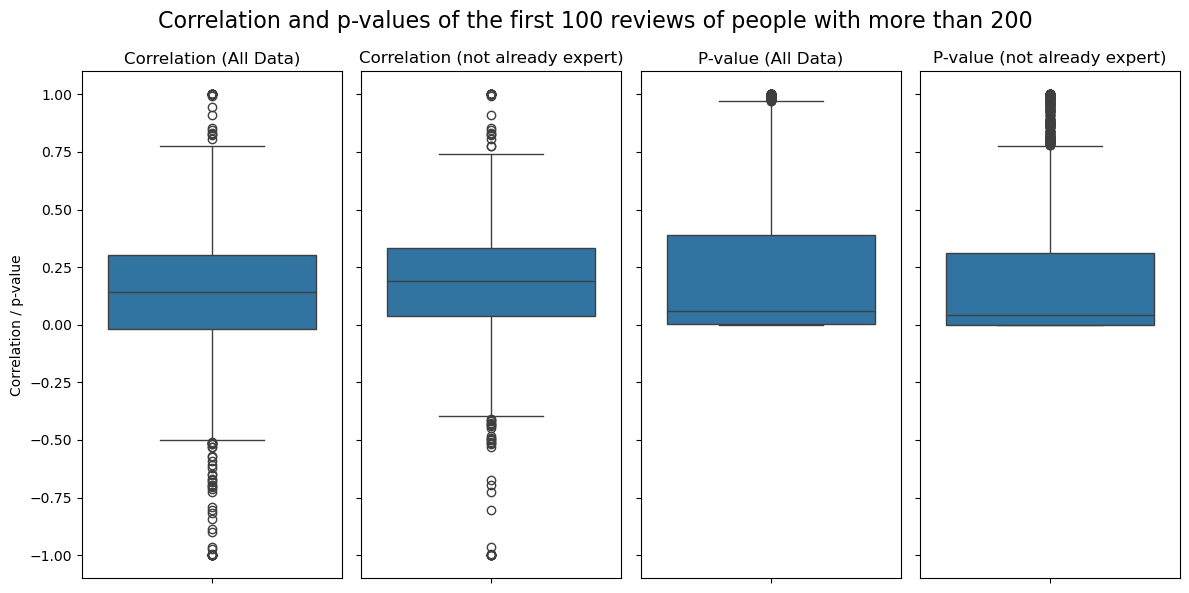

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey = True) 

fig.suptitle("Correlation and p-values of the first 100 reviews of people with more than 200", fontsize=16)
sns.boxplot(y=result['correlation'], ax=axes[0])
axes[0].set_title("Correlation (All Data)")
axes[0].set_ylabel("Correlation / p-value")

sns.boxplot(y=result[result.index.isin(no_already_experts)]['correlation'], ax=axes[1])
axes[1].set_title("Correlation (not already expert)")

sns.boxplot(y=result['p_value'], ax=axes[2])
axes[2].set_title("P-value (All Data)")

sns.boxplot(y=result[result.index.isin(no_already_experts)]['p_value'], ax=axes[3])
axes[3].set_title("P-value (not already expert)")

plt.tight_layout()
plt.show()

In [25]:
result[result.index.isin(no_already_experts)].correlation.mean()

0.17875228244971667

In [26]:
result[result.index.isin(no_already_experts)].p_value.describe()

count    2.483000e+03
mean     1.987175e-01
std      2.812187e-01
min      5.782542e-26
25%      7.811244e-04
50%      4.101114e-02
75%      3.116672e-01
max      1.000000e+00
Name: p_value, dtype: float64

__Using and incremental count instead of the date__

In [27]:

rev_exp_std = standardize(rev_with_scores_rb, scores_for_beer.reset_index(), exp_categories)


/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_metric/../analysis_helper.py:93: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])


In [28]:
result_rep_date = rev_exp_std.groupby('user_id').apply(lambda group: corr_and_count(group, replace_date=True), include_groups=False)
result_rep_date = result_rep_date.dropna()

/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_metric/../analysis_helper.py:138: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_metric/../analysis_helper.py:138: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))
/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_metric/../analysis_helper.py:138: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  correlation, p_value = pearsonr(group[att_1], group['date'].astype(int))


In [29]:
len(result_rep_date)

37554

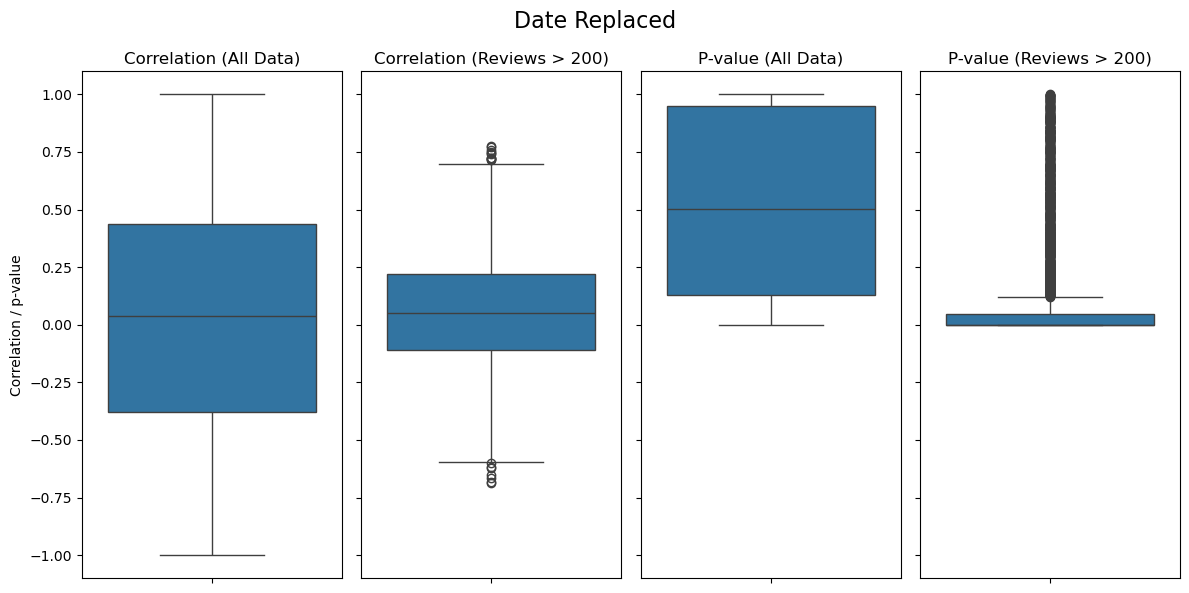

In [30]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey = True) 

fig.suptitle('Date Replaced', fontsize=16)
sns.boxplot(y=result_rep_date['correlation'], ax=axes[0])
axes[0].set_title("Correlation (All Data)")
axes[0].set_ylabel("Correlation / p-value")

sns.boxplot(y=result_rep_date[result_rep_date['total_count'] > 200]['correlation'], ax=axes[1])
axes[1].set_title("Correlation (Reviews > 200)")

sns.boxplot(y=result_rep_date['p_value'], ax=axes[2])
axes[2].set_title("P-value (All Data)")

sns.boxplot(y=result_rep_date[result_rep_date['total_count'] > 200]['p_value'], ax=axes[3])
axes[3].set_title("P-value (Reviews > 200)")


plt.tight_layout()  
plt.show()

In [31]:
result_rep_date[(result_rep_date['total_count'] > 20) & (result_rep_date['total_count'] < 500)]['correlation'].mean()

0.046795628164390375

In [32]:
result_rep_date['correlation'].mean()

0.023830222642082385

In [33]:
rev_of_exp = review_of_experts(rev_with_scores_rb, users, nbr_rev=200)
rev_of_exp = first_reviews(rev_of_exp, max=100)


rev_exp_std = standardize(rev_of_exp, scores_for_beer.reset_index(), exp_categories)
result_rep_date = rev_exp_std.groupby('user_id').apply(lambda group: corr_and_count(group, replace_date=True), include_groups=False)
result_rep_date = result_rep_date.dropna()

/Users/alessandrodimaria/Desktop/Ada_dataset/src/scripts/expert_metric/../analysis_helper.py:93: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  y_copy = y.drop(columns=['review_count'])


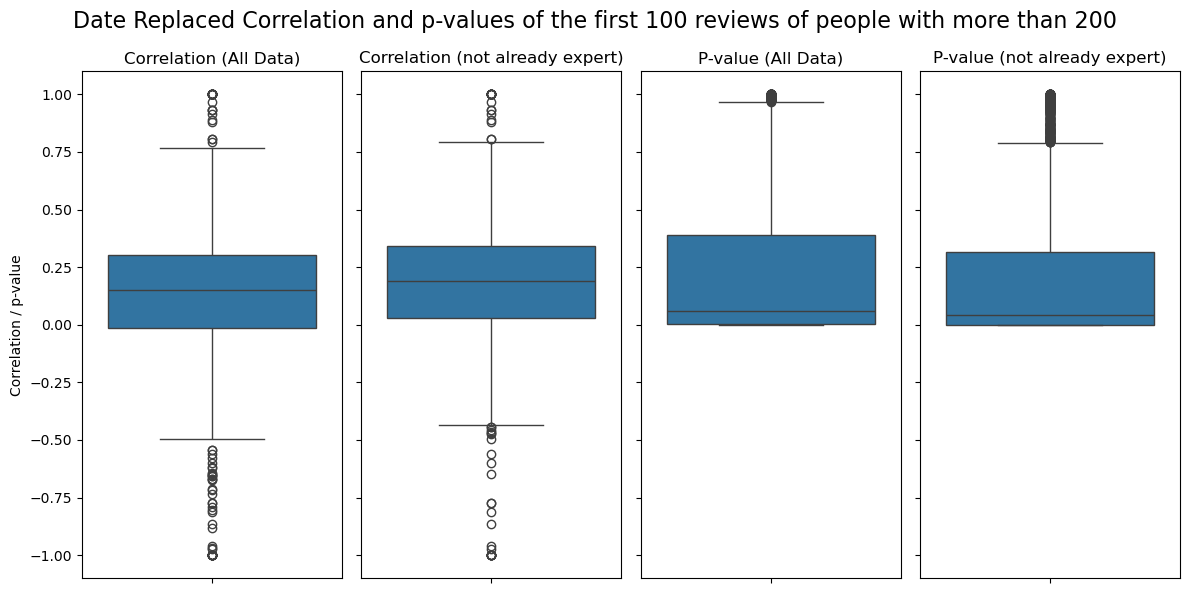

In [34]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True) 


fig.suptitle("Date Replaced Correlation and p-values of the first 100 reviews of people with more than 200", fontsize=16)
sns.boxplot(y=result_rep_date['correlation'], ax=axes[0])
axes[0].set_title("Correlation (All Data)")
axes[0].set_ylabel("Correlation / p-value")

sns.boxplot(y=result_rep_date[result_rep_date.index.isin(no_already_experts)]['correlation'], ax=axes[1])
axes[1].set_title("Correlation (not already expert)")

sns.boxplot(y=result_rep_date['p_value'], ax=axes[2])
axes[2].set_title("P-value (All Data)")

sns.boxplot(y=result_rep_date[result_rep_date.index.isin(no_already_experts)]['p_value'], ax=axes[3])
axes[3].set_title("P-value (not already expert)")

plt.tight_layout()
plt.show()

In [35]:
result_rep_date[result_rep_date.index.isin(no_already_experts)].correlation.mean()

0.18215062662397502

In [36]:
result_rep_date.correlation.mean()

0.14017826502693645

In [37]:
result_rep_date[result_rep_date.index.isin(no_already_experts)].p_value.describe()

count    2.492000e+03
mean     2.026517e-01
std      2.901570e-01
min      4.766502e-24
25%      6.453872e-04
50%      4.106373e-02
75%      3.165875e-01
max      1.000000e+00
Name: p_value, dtype: float64